# CASE STUDY - convolutional neural networks

### Python 3.8.10 used for this notebook, TensorFlow needs an old version of Python to install properly.

In [22]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import csv
import joblib
import time
from collections import Counter

In [23]:
import pandas as pd
import numpy as np
print(np.__version__)

1.24.4


In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

In [25]:
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')
%matplotlib inline

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

# Synopsis

There are also some projects relating to user comments that are getting off the ground.  However, I also work alongside the deep-learning specialists that maintain the core product at AAVAIL---its audio and visual manipulation models.

The team meets regularly and all new data science hires are expected to go through a series deep-learning tutorials to ensure that they can contribute to conversations about the core product.  This notebook will be apart of these tutorials on CNN's. 

Outline fo the guide:

  1. Environment setup
  2. Model scaffolding using Keras
  3. Logging and Model serialization
  4. Model iteration

## Fashion MNIST

>One project that the data science team at AAVAIL has been tasked with is ensuring that the video feeds are in fact news video feeds.  There are people that are performing quality assurance on these feeds, but eventually the data science team will need to build a service that samples a number of frames from a video, then identifies objects in the images, flagging for review any feeds that may be different.

A solid benchmark dataset for this task is the Fashion MNIST dataset.  

* training set - 60,000 images
* test set - 10,000 images
* images are 28 pixels x 28 pixels
* classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot

## PART 1 - environment setup

In [27]:
## if you wish to work with tensorflow v1 then ask it to emulate version 2 behavior
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
print(tf.__version__)

## check hardware availability
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2.7.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6260334704570626944
xla_global_id: -1
]


In [28]:
### load the data  
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data() 
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 
               'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(class_names)

## Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

X_train = train_images
X_test = test_images
y_train = train_labels
y_test = test_labels

### QUESTION 1

Visualize a sample of the images to QA the data set (for instance plot one image of each class). Then, print a summary of the data (for instance, the shape of training set, the shape of the test set, the number of sample per class...).

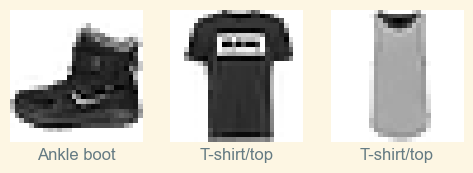

In [29]:
# Visualize 3 images from the dataset

plt.figure(figsize=(10,10))
for i in range(3):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()


In [30]:
# Add a channel dimension to the training and test sets
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# print out data on the shapes of the training and test sets
print("Training data:")
print("Number of examples: ", X_train.shape[0])
print("Number of channels:", X_train.shape[3])
print("Image size:", X_train.shape[1], X_train.shape[2])
print(" ")
print("Test data:")
print("Number of examples:", X_test.shape[0])
print("Number of channels:", X_test.shape[3])
print("Image size:", X_test.shape[1], X_test.shape[2])



Training data:
Number of examples:  60000
Number of channels: 1
Image size: 28 28
 
Test data:
Number of examples: 10000
Number of channels: 1
Image size: 28 28


In [31]:
# print out information on the training classes
print("Training labels:")
print("Number of classes:", len(np.unique(y_train)))
print("Classes:", np.unique(y_train))

Training labels:
Number of classes: 10
Classes: [0 1 2 3 4 5 6 7 8 9]


Take a moment to understand how the data set is built, especially what are the 3 dimensions of X_train and X_test.

### QUESTION 2

In this question you are asked to build a base model. The base model that we want to build is composed of a PCA model followed by a classic machine learning classifier. The PCA takes as input the images that have been flattened and creates a representation of the images with few features (the first n principal components). Then, the classifier will classify the images based on this reduced representation. Following the best practices we will create a sklearn Pipeline and pass this pipeline in a grid search to optimize the hyper parameters. You are free to use the classifier that you think will perform best in this pipeline.

In [37]:
# First we flatten the images to have a data shape that can be ingested by the PCA model.
# Take a moment to understand what does this function (flatten()) do to the images 
# and why this step is necessary.
X_train_flat = np.array([i.flatten() for i in train_images])
X_test_flat = np.array([i.flatten() for i in test_images])

pca = PCA(n_components=0.90, random_state=42)
estimator = RandomForestClassifier(random_state=42)

pipe = Pipeline([('pca', pca),
                 ('clf', estimator)])

# Add the hyper-parameters that you want to optimize during your training
param_grid = {
    'pca__n_components': [0.90],
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, 20]
}

## we create a "saved" folder to save the trained model. 
if not os.path.isdir("saved"):
    os.mkdir("saved")

saved_model_filename = os.path.join("saved", 'ml-model.joblib')
if not os.path.exists(saved_model_filename):
    time_start = time.time()
    
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
    grid.fit(X_train_flat, y_train)
        
    print("saving the pipeline")
    joblib.dump(grid, saved_model_filename)
    print("train time", time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))
else:
    print("loading {} from file".format(saved_model_filename))
    grid = joblib.load(saved_model_filename)

c:\USERS\WILLL\ONEDRIVE\DESKTOP\MY_DOCUMENTS\WILLS_PY_FOLDER\STAMP_PROJECT\TF_ENV\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
11 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
11 fits failed with the following error:
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 287. MiB for an array with shape (48000, 784) and data type float64

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\USERS\WILLL\ONEDRIVE\DESKTOP\MY_DOCUMENTS\WILLS_PY_FOLDER\STAMP_PROJECT\TF_ENV\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_para

saving the pipeline
train time 00:09:04


In [38]:
# Evaluate your model using the classification_report() function
y_pred = grid.predict(X_test_flat)
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.75      0.81      0.78      1000
     Trouser       0.99      0.94      0.97      1000
    Pullover       0.72      0.75      0.73      1000
       Dress       0.80      0.86      0.83      1000
        Coat       0.70      0.76      0.73      1000
      Sandal       0.87      0.89      0.88      1000
       Shirt       0.64      0.45      0.53      1000
     Sneaker       0.91      0.88      0.89      1000
         Bag       0.90      0.94      0.92      1000
  Ankle boot       0.89      0.93      0.91      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



## PART 2 -  model scaffolding using Keras

Create a function that returns a model using ``keras.models.Sequential()`` and ensure that you pass ``activation_function`` as an argument.  Instaintiate a version of the model and print the summary.  This function is just meant to return a simple multilayer perceptron network.


### QUESTION 3

In this question you are asked to build a function that created a simple multilayer perceptron network. To build a sequential model we first need to initialize the Sequential object, then we sequentially add the layers of the model to that object using the add() method.

If your are not familiar with the Sequential class of Keras take a quick look at this documentation : https://keras.io/api/models/sequential/

The following link list all the layers that you can add to a Keras sequential object : https://keras.io/api/layers/


In [39]:
def build_mlp(activation_fn='relu'):
    """
    This Function creates a simple Dense (or multilayer perceptron) network.
    """
    
    # Initialize the Sequential object
    model = keras.Sequential()
    # add a Flatten layer to the sequence
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    # add a Dense layer to the sequence
    model.add(keras.layers.Dense(128, activation='relu'))
    # add the last dense layer to the sequence. Because this is the output layer, 
    # the output dimension should be equal to the number of class that your want to predict.
    model.add(keras.layers.Dense(10, activation='softmax'))    

    return model
# define the activation function

model_simple = build_mlp(activation_fn='relu')
model_simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


We encourage you to modify the structure of the network. You can add new layers, change the number of neurons per layer or add dropout layers.

### QUESTION 4

Create another version of your neural network.  This time you should build a proper CNN.  Remember that one pattern to consider starting from is alternating ``Con2D`` and ``MaxPooling2D`` layers.  This is often followed by a couple of ``Dense`` layers.  Recall that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The output of the last ``Dense`` layer should correspond to the number of classes and generally uses a 'softmax' activation.  Use `model.summary()` to ensure a cohesive architecture.

In [42]:
def build_cnn(activation_fn='relu'):
    """
    This function creates a convolutional neural network (cnn)
    """
    
    # Initialize the Sequential object
    model = keras.Sequential()
    
    #Add a CNN2D layer. Because this is the first layer, you have to specify the input shape for this layer.
    # (Hint : the input shape is (28, 28, 1) for black and white images of size 28x28)
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    #Add a Maxpooling layer
    model.add(keras.layers.MaxPooling2D((2, 2)))
    #Add a CNN2D layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    #Add a Maxpooling layer
    model.add(keras.layers.MaxPooling2D((2, 2)))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation=activation_fn))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model 


model = build_cnn(activation_fn='relu')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 64)               

## PART 3 - logging and Model serialization

You can use a trained model without having to retrain it.  Your can also continue training a model to pick-up training where you left off.  The `tf.keras.callbacks.ModelCheckpoint` callback allows to continually save the model both during and at the end of training.  For long running models this is ideal in case the training is interrupted.  Otherwise you can 
used `model.save()` and `model.load()`.  In this part you will create a function that accomplished a few things at once. 

### QUESTION 5

In this question you will create a function that intend to :

1. save your models so that each iteration only needs to be run once
2. save the specifics of your model in a log file 

  * optimizer 
  * loss_fn 
  * test_loss
  * test_accuracy
  * any notes

In [43]:
def train_network(model_name, model, loss_fn, X_train, y_train, X_test, y_test, optimizer='adam'):
    """
    This function compiles, trains and saves the keras model
    Input : 
        - model_name : the name of the model (we will save the model under this name)
        - model : The keras Sequential model
        - loss_fn : the name of the loss function used to train the model (https://keras.io/api/losses/)
        - optimizer : the name of the optimizer used to train the model (https://keras.io/api/optimizers/)
        - X_train : the training data
        - y_train : the training labels
        - X_test : the test data
        - y_test : the test labels
    """

    # First we create a filename for the model joining its name with the "saved" directory
    save_dir = 'saved'
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
    saved_model = os.path.join(save_dir, "{}.h5".format(model_name))

    ## if the model has not been trained, we compile it, train it and save it
    if not os.path.exists(saved_model):
        ## compile model using the compile method of the keras.models.Sequential class
        model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
                
        ## fit the model using the fit method of the keras.models.Sequential class
        ## (choose 10 epochs and batch size of 64)
        model.fit(X_train, y_train, epochs=10, batch_size=64)
        
        # Save the model
        model.save(saved_model)

        ## evaluate the model 
        test_loss, test_acc = model.evaluate(X_test, y_test)
        
        ## save a log file
        log_file = os.path.join(save_dir,"{}.log".format(model_name)) 
        with open(log_file, 'w') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["loss_function", loss_fn])
            writer.writerow(["optimizer", optimizer])
            writer.writerow(["test_loss", test_loss])
            writer.writerow(["test_acc", test_acc])

    # if the model has already been trained we load it.
    else:
        print("... loading saved model")
        model = keras.models.load_model(saved_model)
                    
    return model

## PART 4 - model iteration

### Question 6

Using the functions that you created in the previous questions build the model and train it on the MNIST dataset.

Epoch 1/10
938/938 [==============================] - 1s 840us/step - loss: 0.5183 - accuracy: 0.8203
Epoch 2/10
938/938 [==============================] - 1s 805us/step - loss: 0.3851 - accuracy: 0.8611
Epoch 3/10
938/938 [==============================] - 1s 803us/step - loss: 0.3472 - accuracy: 0.8746
Epoch 4/10
938/938 [==============================] - 1s 800us/step - loss: 0.3215 - accuracy: 0.8833
Epoch 5/10
938/938 [==============================] - 1s 828us/step - loss: 0.3062 - accuracy: 0.8880
Epoch 6/10
938/938 [==============================] - 1s 827us/step - loss: 0.2898 - accuracy: 0.8928
Epoch 7/10
938/938 [==============================] - 1s 841us/step - loss: 0.2768 - accuracy: 0.8988
Epoch 8/10
938/938 [==============================] - 1s 801us/step - loss: 0.2680 - accuracy: 0.9009
Epoch 9/10
938/938 [==============================] - 1s 829us/step - loss: 0.2580 - accuracy: 0.9046
Epoch 10/10
313/313 [==============================] - 0s 681us/step - loss: 0.342

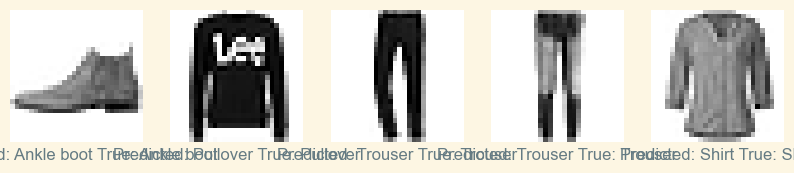

In [48]:
# build and train the simple model on the training data
model_simple = build_mlp(activation_fn='relu')
model_simple = train_network("simple_model", model_simple, 'sparse_categorical_crossentropy', X_train, y_train, X_test, y_test)



# Evaluate the simple model
test_loss, test_acc = model_simple.evaluate(X_test, y_test)
print("Simple model, accuracy: {:5.2f}%".format(100*test_acc))



# Predict the class of the first 5 test images using the simple model
predictions = model_simple.predict(X_test)
print("Simple model predictions:")
for i in range(5):
    print("Predicted class: ", np.argmax(predictions[i]))
    print("True class: ", y_test[i])
    print(" ")
    

# Visualize the first 5 test images and their predicted classes
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel("Predicted: {} True: {}".format(class_names[np.argmax(predictions[i])], class_names[y_test[i]]))
plt.show()

In [49]:
# For the CNN we have to add a third dimension to each sample image.

# This dimension is called channel and is expected by the CNN2D layer. 
# Here the channel value is 1 because we have black and white images. 
# We would have to set this value to 3 for colored images.
X_train_1 = np.expand_dims(X_train, -1)
X_test_1 = np.expand_dims(X_test, -1)

Epoch 1/10
938/938 [==============================] - 16s 17ms/step - loss: 0.5017 - accuracy: 0.8176
Epoch 2/10
938/938 [==============================] - 22s 23ms/step - loss: 0.3332 - accuracy: 0.8782
Epoch 3/10
938/938 [==============================] - 21s 22ms/step - loss: 0.2891 - accuracy: 0.8936
Epoch 4/10
938/938 [==============================] - 20s 22ms/step - loss: 0.2570 - accuracy: 0.9054
Epoch 5/10
938/938 [==============================] - 22s 24ms/step - loss: 0.2361 - accuracy: 0.9136
Epoch 6/10
938/938 [==============================] - 22s 23ms/step - loss: 0.2136 - accuracy: 0.9210
Epoch 7/10
938/938 [==============================] - 20s 21ms/step - loss: 0.1968 - accuracy: 0.9273
Epoch 8/10
938/938 [==============================] - 20s 21ms/step - loss: 0.1802 - accuracy: 0.9337
Epoch 9/10
938/938 [==============================] - 20s 21ms/step - loss: 0.1668 - accuracy: 0.9391
Epoch 10/10
313/313 [==============================] - 1s 3ms/step - loss: 0.2624 

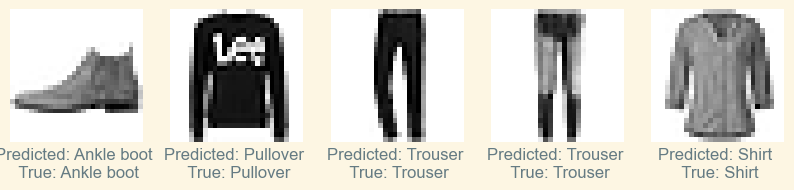

In [50]:
# build and train the cnn model on the training data
model_cnn = build_cnn(activation_fn='relu')
model_cnn = train_network("cnn_model", model_cnn, 'sparse_categorical_crossentropy', X_train_1, y_train, X_test_1, y_test)

# Evaluate the cnn model
test_loss, test_acc = model_cnn.evaluate(X_test_1, y_test)
print("CNN model, accuracy: {:5.2f}%".format(100*test_acc))

# Predict the class of the first 5 test images using the cnn model
predictions = model_cnn.predict(X_test_1)
print("CNN model predictions:")
for i in range(5):
    print("Predicted class: ", np.argmax(predictions[i]))
    print("True class: ", y_test[i])
    print(" ")

# Visualize the predictions of the cnn model
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel("Predicted: {} \n True: {}".format(class_names[np.argmax(predictions[i])], class_names[y_test[i]]))
plt.show()